The input of the NN is 1D. 

In [1]:
import numpy as np
import copy
import torch
import torch.nn as nn
import math
from torch.autograd import Variable
import matplotlib.pyplot as plt

def quad_fn(a, b, c, x):
    return a*x**2 + b*x + c

def x_square(x: torch.tensor) -> torch.Tensor:
    return x**2

# DEFINE GIVEN FUNCTION V(x): ax^2 + bx + c
given_fn = x_square

In [ ]:
# CUSTOM LOSS FUNCTION:
# def EpsilonLoss(nn.Module):

def epsilon_Loss(v_x, model_u, lower_bound, upper_bound, n_points):
    """
    GOAL: Epsilon function evaluated at u using discretized estimation
    minimizing Epsilon(u) = 
    
    ARGS: 
    n_points (int): number of discretized points on the interval [-L, L]
    e.g.: -(L)|---|---|---|---|(L) interval has n_points = 5

    v_x (torch.Tensor): function instance
    model_u (torch.Tensor): model output
    """
    total = 0
    discrete_points = np.linspace(lower_bound, upper_bound, n_points)
    h = discrete_points[1] - discrete_points[0]
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
        u_xi = model_u(x_i)

        u_prime = model_u.u_prime_2(x_i)
        
        v_xi = v_x.forward(x_i)
        t = torch.abs(torch.square(u_prime)) + v_xi*(u_xi**2)
        total += t
    return 0.5*h*total

def epsilon_Loss_penalty(v_x, model_u, lambda_pen,
                         lower_bound, upper_bound, n_points):
    """
    
    """
    eps_sum = 0
    pen = 0

    discrete_points = np.linspace(lower_bound, upper_bound, n_points)
    h = discrete_points[1] - discrete_points[0]
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
        u_prime = model_u.u_prime_2(x_i)
        
        u_xi = model_u(x_i)
        v_xi = v_x.forward(i)

        t = torch.abs(torch.square(u_prime)) + v_xi*torch.square(u_xi)
        eps_sum += t
    epsilon_fn = 0.5*h*eps_sum
    
    temp = 0
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
        temp += torch.square(model_u(x_i))
    
    pen = lambda_pen * torch.square((h * temp-1))
    return epsilon_fn + pen 

# NORMALIZE MODEL u(x) OUTPUT:
def normalize_u(model_u, lower_bound, upper_bound, n_points):
    """
    Normalize model.output weight by: 
    model.output *= c
    where,
    scalar c = 1/denom
    """
    discrete_points = np.linspace(lower_bound, upper_bound, n_points)
    h = discrete_points[1] - discrete_points[0]
    s = 0
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
        s += model_u(x_i)**2
    denom = math.sqrt(h) * torch.sqrt(s)
    return 1/denom

In [ ]:
# CREATING MODEL CLASS
class Nonlinear(nn.Module):
    def __init__(self, n):
        # One hidden layer with n nodes
        super().__init__()
        self.hidden = nn.Linear(1, n)
        self.output = nn.Linear(n, 1)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.target_fn = given_fn

    def forward(self, x, use_tanh_fn = False):
        if use_tanh_fn == True:
            x = self.hidden(x)
            x = self.tanh(x)
            x = self.output(x)
        else:
            x = self.hidden(x)
            x = self.sigmoid(x)
            x = self.output(x)
        return x

    def normalize_model(self, lower_bound, upper_bound, n_points):
        """
        GOAL: Normalize the output weight layer
        """
        print("Before normalization: ")
        print(self.output.weight.data)
        print(self.output.bias.data)
        
        c = normalize_u(self, lower_bound, upper_bound, n_points)
        self.output.weight.data.copy_(c.item() * self.output.weight.data)
        self.output.bias.data.copy_(c.item() * self.output.bias.data)

        print("After normalization: ")
        print(self.output.weight.data)
        print(self.output.bias.data)
        print("c value = " + str(c))

        return 

    def u_prime_2(self, input):
        i_tensor = torch.tensor([input.item()], requires_grad=True, dtype=torch.float)
        clone_model = copy.deepcopy(self)
        res = clone_model(i_tensor)
        res.backward()
        
        val = 0
        val += i_tensor.grad

        del i_tensor
        del clone_model
        
        return val

    def u_prime(self, input):
        """
        NN with 1 hidden node layer is of the form:
        u(x) = SUM_i_to_N(a_i * sigmoid(w.x + b))

        where
        a_i is the corresponding weight of self.output layerq
        w is self.hidden.weight vector
        b is self.hidden.bias vector
        sigmoid(w.x + b) is the sigmoid-activated hidden vector

        Formula of u'(x) (for 1 hidden layer NN):
        u'(x) = SUM_i_to_N(w_i*a_i*sigmoid'(w_i*x+b))
        Note: sigmoid'(w_i*x +b) = sigmoid(w_i*x+b)*(1-sigmoid(w_i*x+b))
        """
        a_i = self.output.weight.data
        w_i = torch.transpose(self.hidden.weight.data, 0, 1)
        wi_ai = w_i * a_i

        hid_layer = self.hidden(input)
        hid_layer_T = torch.reshape(hid_layer, (list(hid_layer.shape)[0], 1))
        m = hid_layer_T * (1-hid_layer_T)

        return wi_ai @ m
    
# TRANING MODEL
    def train_network_with_penalty(self, num_epochs, v_x, optimizer, lambda_pen,
                                    lower_bound, upper_bound, n_points):
        # For plotting loss value over epochs:
        x_epochs = []
        y_loss = []
        y_loss_pen = []

        # stopping criterion:
        stop_counter = 0

        for epoch in range(num_epochs):
            optimizer.zero_grad()
            loss_pen = epsilon_Loss_penalty(v_x, self, lambda_pen,
                                        lower_bound, upper_bound, n_points)
            loss = epsilon_Loss(v_x, self,
                                lower_bound, upper_bound, n_points)
            
            y_loss_pen.append(loss_pen.detach().numpy().item())
            y_loss.append(loss.detach().numpy().item())
            x_epochs.append(epoch)

            #check if need to stop training:
            if epoch > 0 and stop_counter >= 5:

                #Normalize model before return
                self.normalize_model(lower_bound, upper_bound, n_points)

                print("LOSS VALUE WITH LAMBDA PENALTY = " 
                      + str(epsilon_Loss_penalty(v_x, self, lambda_pen,
                                                 lower_bound, upper_bound, n_points)))
                print("LOSS VALUE  = " 
                      + str(epsilon_Loss(v_x, self, lower_bound, upper_bound, n_points)))
                
                break
            elif epoch > 0 and stop_counter < 5:
                if torch.abs(y_loss_pen[epoch-1]-loss_pen) <= 1e-5:
                    stop_counter += 1
                else:
                    stop_counter = 0
            else:
                print("Uncatched case")

            print('epoch {}, loss with penalty {}'.format(epoch, loss_pen.item()))
            loss_pen.backward()
            optimizer.step()

        return (x_epochs, y_loss_pen, y_loss)

    def train_network(self, num_epochs, v_x, optimizer,
                                    lower_bound, upper_bound, n_points):
        # For plotting loss value over epochs:
        x_epochs = []
        y_loss = []
        
        # stopping criterion:
        stop_counter = 0

        for epoch in range(num_epochs):

            if epoch > 0 and epoch % 50 == 0:
                c = normalize_u(self, lower_bound, upper_bound, n_points)
                print("Pre normalize: ")
                print(self.output.weight.data)
                print(self.output.bias.data)
                print("After normalize: ")
                
                self.normalize_model(lower_bound, upper_bound, n_points)
                
                print(self.output.weight.data)
                print(self.output.bias.data)
                print("c value = " + str(c))
            optimizer.zero_grad()
            loss = epsilon_Loss(v_x, self,
                                lower_bound, upper_bound, n_points)
            y_loss.append(loss.detach().numpy().item())
            x_epochs.append(epoch)
            #check if need to stop training:
            if epoch > 0 and stop_counter >= 5:
                print("LOSS VALUE = " 
                      + str(epsilon_Loss(v_x, self, lower_bound, upper_bound, n_points)))
                break
            elif epoch > 0 and stop_counter < 5:
                if torch.abs(y_loss[epoch-1]-loss) <= 1e-5:
                    stop_counter += 1
                else:
                    stop_counter = 0

            print('epoch {}, loss {}'.format(epoch, loss.item()))
            loss.backward()
            optimizer.step()

        return (x_epochs, y_loss)
        

In [2]:
# DEFINE HYPER-PARAMETERS
batch_size = 50
learningRate = 0.05
num_epochs = 2000

#INIT MODEL
model = Nonlinear(20)
if torch.cuda.is_available():
    model.cuda()

# INIT OPTIMIZER CLASS
# Adam:
adam_optimizer = torch.optim.Adam(model.parameters(), 
                                    lr=learningRate, 
                                    betas=(0.9, 0.999), 
                                    eps=1e-08, 
                                    weight_decay=0, 
                                    amsgrad=False)

NameError: ignored

In [3]:
INPUT_SIZE = 1
OUTPUT_SIZE = 1

LAMBDA_PEN = 100
LOWER_BOUND = -6
UPPER_BOUND = 6
N_POINTS = 1000

# CREATING DATASET:
x_values = [i for i in np.linspace(LOWER_BOUND, UPPER_BOUND, N_POINTS)]
y_values = [given_fn(i) for i in x_values]

x_train = np.array(x_values, dtype=np.float32).reshape(-1, 1)
y_train = np.array(y_values, dtype=np.float32).reshape(-1, 1)

print(x_train.shape, y_train.shape)

(1000, 1) (1000, 1)


In [ ]:
model_2 = Nonlinear(20)
adam_optimizer_2 = torch.optim.Adam(model_2.parameters(), 
                                    lr=learningRate, 
                                    betas=(0.9, 0.999), 
                                    eps=1e-08, 
                                    weight_decay=0, 
                                    amsgrad=False)


In [4]:
# PLOT DATA
def plot_figure(x_val, y_val, x_test=None, predicted=None):
    plt.clf()
    plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(x_val, y_val, '--', label='True data', alpha=0.5)
    if predicted != None:
        plt.plot(x_test, predicted, '--', label='Predictions', alpha=0.5)
    plt.legend(loc='best')
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#SAVE MODEL TO DRIVE
model_save_name = 'latest_model.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

In [ ]:
#LOAD MODEL FROM DRIVE
model_save_name = 'latest_model.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
graph_val_pen = model.train_network_with_penalty(num_epochs, given_fn, adam_optimizer, LAMBDA_PEN, LOWER_BOUND, UPPER_BOUND, N_POINTS)

In [ ]:
graph_val = model_2.train_network(num_epochs, given_fn, adam_optimizer_2, LOWER_BOUND, UPPER_BOUND, N_POINTS)

In [ ]:
### Model result using epsilon loss function with penalty
print("Penalty lambda value = " + str(LAMBDA_PEN))
print("Interval is [{lb}, {ub}], with N_POINTS = {npoint}".format(lb=LOWER_BOUND, 
                                                              ub=UPPER_BOUND,
                                                              npoint=N_POINTS))
print("\n")

# Plot 1: The epsilon_loss with lambda penalty:
print("Plot 1: The epsilon_loss_with_penalty along the training epochs:")
x_epochs = graph_val_pen[0]
plot_figure(x_epochs, graph_val_pen[1])

print("\n")
# Plot 2: The epsilon_loss value when using train with penalty:
print("Plot 2: The epsilon_loss value along the training epochs:")

plot_figure(x_epochs, graph_val_pen[2])
print("\n")

# plot_figure(x_values, model_output)

Plot 3: the model's output with input from the interval: 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 432x288 with 0 Axes>

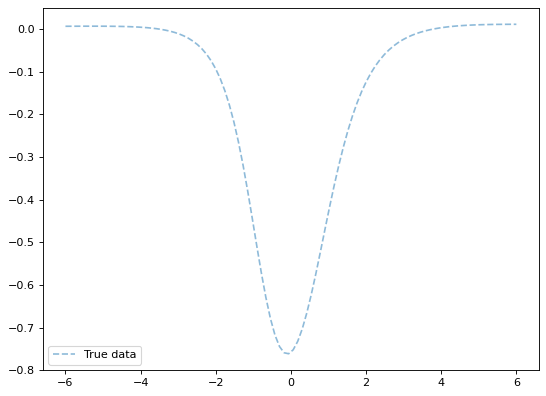

In [ ]:
# Plot 3: the model's output with input from the interval [LOWER_BOUND, UPPER_BOUND]:
print("Plot 3: the model's output with input from the interval: ")
x_vals = [torch.tensor([i], requires_grad=True, dtype=torch.float) for i in x_train]

model_output = []
for i in x_vals:
    model_output.append(model(i).detach().numpy().item())

plot_figure(x_values, model_output)

In [ ]:
epsilon_Loss(given_fn, model, -6, 6, 1001)

tensor([23.2552], grad_fn=<MulBackward0>)

<Figure size 432x288 with 0 Axes>

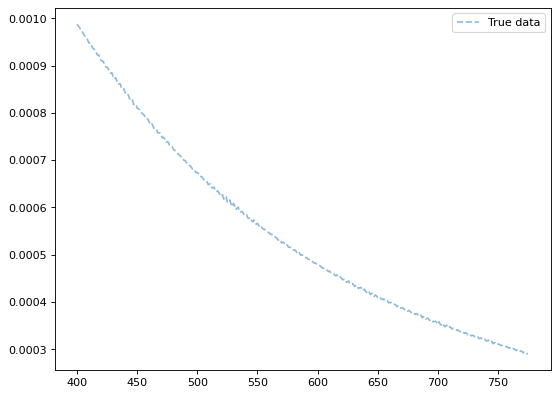

In [ ]:
diff = [None for i in range(len(graph_val_pen[2]))]
for i in range(len(graph_val_pen[2])):
    diff[i] = abs(graph_val_pen[2][i]-graph_val_pen[1][i])

plot_figure(x_epochs[400:], diff[400:])

<Figure size 432x288 with 0 Axes>

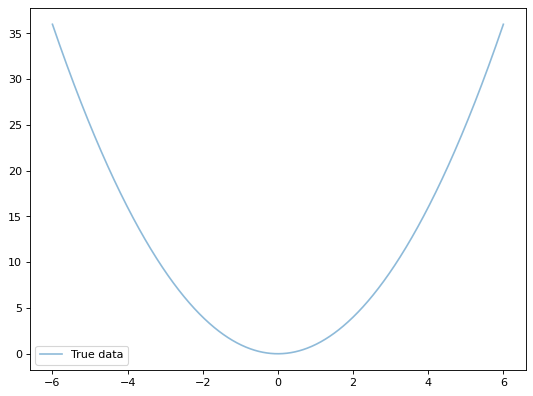

In [ ]:
plot_figure(x_train, y_train)

# HOW TO TRAIN THE NN MODEL:
1. Reset adam_optimizer: 
```adam_opt.zero_grad()```
2. Calculate loss
3. Update the optimizer: 
```adam_opt.step()```


        weight = weight - lr * gradient

-> use lr and gradient to "improve" weight layer. 

Explanation:
```adam_opt.step()```: Update the model's parameters 


https://neptune.ai/blog/pytorch-loss-functions
https://stackoverflow.com/questions/53980031/pytorch-custom-loss-function
https://stackoverflow.com/questions/65947284/loss-with-custom-backward-function-in-pytorch-exploding-loss-in-simple-mse-exa
https://www.youtube.com/watch?v=ma2KXWblllc

In [ ]:
finite_diff_method(LOWER_BOUND, UPPER_BOUND, N_POINTS, given_fn)

(array([0.999991]),
 array([-1.51713800e-09, -3.04192274e-09, -4.58197678e-09, ...,
        -4.58198910e-09, -3.04193106e-09, -1.51714438e-09]))

In [ ]:
a = float(input('enter lower limit of the domain: '))
b = float(input('enter upper limit of the domain: '))
N = int(input('enter number of grid points: '))

enter lower limit of the domain: -6
enter upper limit of the domain: 6
enter number of grid points: 1001


We have the linear system Ax = λx

Then decompose A into H + V, A = H+V

In [ ]:
x = np.linspace(a,b,N)
h = x[1]-x[0]
c = np.sqrt(1/h)

H = np.zeros((N,N))
# Question: Why H has dimension (N-2) x (N-2)?
V = np.zeros((N,N))



In [ ]:
for i in range (N):
    for j in range (N):
        if i == j:
            H[i][j] = -2
        elif abs(i-j) == 1:
            H[i][j] = 1
print(H)

for i in range (N):
    for j in range (N):
        if i == j:
            V[i][j] = given_fn(x[i])
print(V) 

In [ ]:
A = -H/(h**2) + V
print(A)

In [ ]:
# Normalize eig_vec by computing L2 normeig_vec

In [ ]:
eig_val, eig_vec = np.linalg.eig(A)
sorted_id_eig_val = np.argsort(eig_val)
# Get the indices that would sort eig_val
z = sorted_id_eig_val[0:1] # Bc. eig_val first 4 value is in ascending order, 
# eig_val[z] will return sorted first [T] value of eigenvalues.
energies = eig_val[z]/eig_val[z][0]

ground_state = c * eig_vec[:,z[0]]

In [ ]:
eig_val[z]

array([0.999991])

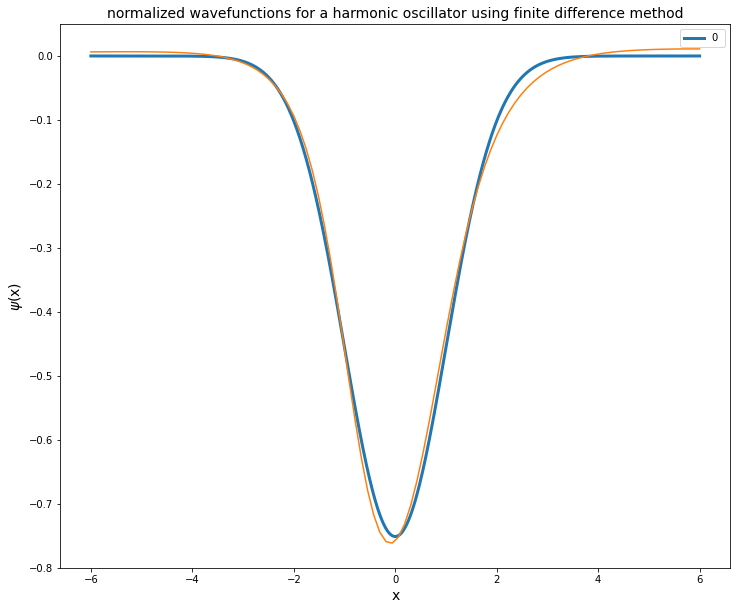

In [ ]:
plt.figure(figsize=(12,10))
for i in range(len(z)):
    y = []
    y = np.append(y, (-1) * -ground_state)

#     print(y)
#     y = np.append(y,0)
#     print(y)
#     print(y)
#     y = np.insert(y,0,0)
#     print(y)
    plt.plot(x,y,lw=3, label="{} ".format(i))
    plt.xlabel('x', size=14)
    plt.ylabel('$\psi$(x)',size=14)
plt.plot(x_values, model_output)
plt.legend()
plt.title('normalized wavefunctions for a harmonic oscillator using finite difference method',size=14)
plt.show()

In [5]:
def finite_diff_method(lower_bound, upper_bound, N_discrete_pts, given_fn):
    discrete_points = np.linspace(lower_bound, upper_bound, N_discrete_pts)
    h = x[1]-x[0]
    c = np.sqrt(1/h)

    H = np.zeros((N,N))
    # Question: Why H has dimension (N-2) x (N-2)?
    V = np.zeros((N,N))

    for i in range (N):
        for j in range (N):
            if i == j:
                H[i][j] = -2
            elif abs(i-j) == 1:
                H[i][j] = 1
    for i in range (N):
        for j in range (N):
            if i == j:
                V[i][j] = given_fn(x[i])

    eig_val, eig_vec = np.linalg.eig(A)
    sorted_id_eig_val = np.argsort(eig_val)
    # Get the indices that would sort eig_val
    z = sorted_id_eig_val[0:1] # Bc. eig_val first 4 value is in ascending order, 
    # eig_val[z] will return sorted first [T] value of eigenvalues.
    energies = eig_val[z]/eig_val[z][0]

    ground_state = c * eig_vec[:,z[0]]

    return (eig_val[z], ground_state)

In [6]:
def plot_finite_diff_sol(eig_val, ground_state):
    plt.figure(figsize=(12,10))
    for i in range(len(eig_val)):
        y = []
        y = np.append(y, (-1) * -ground_state)

        plt.plot(x,y,lw=3, label="{} ".format(i))
        plt.xlabel('x', size=14)
        plt.ylabel('$\psi$(x)',size=14)
    # plt.plot(x_values, model_output)
    plt.legend()
    plt.title('normalized wavefunctions for a harmonic oscillator using finite difference method',size=14)
    plt.show()
    return

In [7]:
class Potential_Function:
    def __init__(self, N_points, L_endpoint, alpha, c_0 = 0):
        self.N_points = N_points
        self.L_endpoint = L_endpoint
        
        self.alpha = alpha
        self.c_0 = c_0

    def forward(self, x):
        """
        ARGS:
        """
        f_value = 0
        summation = 0

        #Iterative method:
        for i in range(1, self.N_points):
            t_i = np.random.normal(loc=0, scale=1.0)
            c_i = (math.pi/(i * self.L_endpoint))**self.alpha
            cos_val = np.cos((i * self.L_endpoint * x)/math.pi)
            summation += t_i * c_i * cos_val

        f_value += summation
        f_value += self.c_0

        return f_value

In [ ]:
t_f = Potential_Function(20, UPPER_BOUND, 3, 10)
res = []
for x_i in np.linspace(LOWER_BOUND, UPPER_BOUND, 100):
    res.append(t_f.forward(x_i))

In [ ]:
min(res)

9.696046892687715

In [ ]:
p_f_res = model.train_network_with_penalty(num_epochs, t_f, adam_optimizer, LAMBDA_PEN, LOWER_BOUND, UPPER_BOUND, N_POINTS)

RuntimeError: ignored

Dear professor, can you help me check if I implement the function correctly:
potential_function_V(N_points, L_endpoint, alpha, input_X, c_0 = 0)

PARAMS:
    c_0 := large random value, will set value later
    input_X := input value X


V(x) = c_0 + SUM from i to N_points ((t_i + c_i + cos(i * L_endpoint * X)/pi)
where,

t_i = np.random.normal(mean=0, std=1)
c_i = (pi/i*L)^alpha


In [ ]:
var = np.random.normal(loc=0, size=(2, ))

In [ ]:
np.random.normal()

-0.06526707942659112